<a href="https://colab.research.google.com/github/Satvik256/TestRepo/blob/master/movielens_collab_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2020-06-01 09:30:30--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  28.8MB/s    in 0.2s    

2020-06-01 09:30:30 (28.8 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [4]:
!unzip /content/ml-100k

Archive:  /content/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
path=Path('/content/ml-100k')

In [0]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,names=['user_id','movie_id','rating','timestamp'])                     

In [7]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=['movie_id', 'title', 'date', 'N', 'url',*[f'g{i}' for i in range(19)]])
movies.head()

,movie_id,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
doc(pd.merge)

In [0]:
rating_movie=pd.merge(ratings,movies,how='inner',on=['movie_id'])

In [0]:
rating_movie=rating_movie[['user_id','movie_id','rating','timestamp','title']]

In [31]:
rating_movie.head()

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data=CollabDataBunch.from_df(rating_movie,seed=30,valid_pct=0.1,item_name='title')

In [55]:
data.show_batch()

user_id,title,target
5,Aladdin and the King of Thieves (1996),4.0
497,In the Army Now (1994),1.0
723,"Empire Strikes Back, The (1980)",4.0
437,"Princess Bride, The (1987)",4.0
333,While You Were Sleeping (1995),5.0


In [0]:
lrn=collab_learner(data,y_range=[0.,5.5],wd=1e-1,n_factors=35)

In [57]:
lrn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


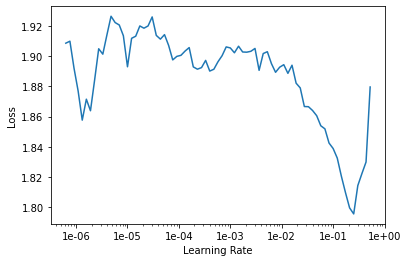

In [58]:
lrn.recorder.plot(skip_end=15)

In [63]:
lrn.fit_one_cycle(4,2e-3)

epoch,train_loss,valid_loss,time
0,0.586910,0.778075,00:17
1,0.592732,0.777030,00:17
2,0.512686,0.777222,00:17
3,0.469248,0.778425,00:17


In [0]:
lrn.save('model-1')

In [65]:
lrn.load('model-1')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
user_id 196; title Kolya (1996); ,user_id 63; title Kolya (1996); ,user_id 226; title Kolya (1996); ,user_id 154; title Kolya (1996); ,user_id 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
user_id 454; title Unforgiven (1992); ,user_id 598; title Saint, The (1997); ,user_id 396; title Independence Day (ID4) (1996); ,user_id 67; title High School High (1996); ,user_id 938; title Willy Wonka and the Chocolate Factory (1971); 
y: FloatList
2.0,4.0,5.0,4.0,4.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 35)
  (i_weight): Embedding(1654, 35)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='

In [0]:
g=rating_movie.groupby('title')['rating'].count()

In [0]:
top_movies=g.sort_values(ascending=False).index.values[:1000]

In [0]:
movie_bias=lrn.bias(top_movies,is_item=True)

In [0]:
mean_ratings=rating_movie.groupby('title').mean()

In [0]:
movie_ratings = [(b, i, mean_ratings.loc[i].rating) for i,b in zip(top_movies,movie_bias)]

In [71]:
sorted(movie_ratings,key=lambda x:x[0],reverse=True)[:15]

[(tensor(0.5148), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4800), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4754), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4738), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4647), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4579), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4383), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4315), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4297), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4146), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4108), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4104), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.3986), 'Apt Pupil (1998)', 4.1),
 (tensor(0.3978), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.3909), 'Godfather, The (1972)', 4.283292978208232)]

In [72]:
sorted(movie_ratings,key=lambda x:x[0])[:15]

[(tensor(-0.4232),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3264),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2820), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2571), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2532), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2494), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2239), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2215),
  'Tales from the Crypt Presents: Bordello of Blood (1996)',
  2.6363636363636362),
 (tensor(-0.2093), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2090), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2090), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2063), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2013), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.1993), 'Mortal Komb

In [73]:
sorted(movie_ratings,key=lambda x:x[0]+x[2],reverse=True)[:15]

[(tensor(0.4738), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4800), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4108), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4146), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.3849), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4383), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4315), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.3383),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.5148), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4647), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.3860), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4297), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.3909), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4104), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.3792), "One Flew Over the Cuckoo's Nest (197

In [0]:
movie_w=lrn.weight(top_movies,is_item=True)

In [75]:
print(movie_w.shape)
movie_w[0]

torch.Size([1000, 35])


tensor([ 0.0554,  0.6373,  0.5307,  0.4475,  0.1865,  0.0517,  0.5827, -0.3607,
         0.4877, -0.1949, -0.4795, -0.3500,  0.5265,  0.0991,  0.4827, -0.4718,
        -0.4654,  0.5206,  0.1854, -0.0220,  0.1230,  0.2888, -0.0620,  0.3631,
        -0.7064,  0.0396,  0.4329,  0.3908,  0.3896, -0.4672,  0.0658, -0.2831,
         0.0713, -0.4066,  0.1758])

In [0]:
movie_pca=movie_w.pca(3)

In [77]:
movie_pca.shape

torch.Size([1000, 3])

In [0]:
f1,f2,f3=movie_pca.t()

In [79]:
movie_comp=[(x,i) for x,i in zip(f1,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(1.2644), 'Home Alone 3 (1997)'),
 (tensor(1.1407), "McHale's Navy (1997)"),
 (tensor(1.1265), 'Jungle2Jungle (1997)'),
 (tensor(1.1262), 'Leave It to Beaver (1997)'),
 (tensor(1.0994), 'Congo (1995)'),
 (tensor(1.0542), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0373), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(1.0367), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0183), 'Children of the Corn: The Gathering (1996)'),
 (tensor(0.9884), 'Striptease (1996)'),
 (tensor(0.9683), 'Batman & Robin (1997)'),
 (tensor(0.9379), 'Mouse Hunt (1997)'),
 (tensor(0.9187), 'Bio-Dome (1996)'),
 (tensor(0.9167), 'Grease 2 (1982)'),
 (tensor(0.9121), 'Beautician and the Beast, The (1997)')]

In [80]:
movie_comp=[(x,i) for x,i in zip(f1,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-1.1360), 'Casablanca (1942)'),
 (tensor(-1.0891), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0325), 'Secrets & Lies (1996)'),
 (tensor(-1.0135), 'Godfather, The (1972)'),
 (tensor(-1.0132), 'Close Shave, A (1995)'),
 (tensor(-0.9928), 'Chinatown (1974)'),
 (tensor(-0.9841),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9332), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(-0.9266), '12 Angry Men (1957)'),
 (tensor(-0.9157), 'Fargo (1996)'),
 (tensor(-0.9047), 'Third Man, The (1949)'),
 (tensor(-0.8945), 'Graduate, The (1967)'),
 (tensor(-0.8898), 'Star Wars (1977)'),
 (tensor(-0.8826), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8806), 'Wrong Trousers, The (1993)')]

In [81]:
movie_comp=[(x,i) for x,i in zip(f2,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(0.8653), 'Trainspotting (1996)'),
 (tensor(0.8436), 'Brazil (1985)'),
 (tensor(0.7746), 'Sweet Hereafter, The (1997)'),
 (tensor(0.7712), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7708), 'Lost Highway (1997)'),
 (tensor(0.7662), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7482), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7387), 'Crumb (1994)'),
 (tensor(0.7267), 'Stuart Saves His Family (1995)'),
 (tensor(0.6984), 'Jude (1996)'),
 (tensor(0.6953), 'Clockwork Orange, A (1971)'),
 (tensor(0.6864), 'Cable Guy, The (1996)'),
 (tensor(0.6829), 'Heavenly Creatures (1994)'),
 (tensor(0.6807), 'Serial Mom (1994)'),
 (tensor(0.6782), 'Exotica (1994)')]

In [82]:
movie_comp=[(x,i) for x,i in zip(f2,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-1.1479), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.1109), 'Titanic (1997)'),
 (tensor(-1.0632), 'Braveheart (1995)'),
 (tensor(-0.9262), 'Forrest Gump (1994)'),
 (tensor(-0.8812), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8625), 'American President, The (1995)'),
 (tensor(-0.8512), 'Star Wars (1977)'),
 (tensor(-0.8197), 'Time to Kill, A (1996)'),
 (tensor(-0.8188), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8105), 'Field of Dreams (1989)'),
 (tensor(-0.8010), 'Return of the Jedi (1983)'),
 (tensor(-0.7993), 'Back to the Future (1985)'),
 (tensor(-0.7893), 'Fugitive, The (1993)'),
 (tensor(-0.7827), "Mr. Holland's Opus (1995)"),
 (tensor(-0.7529), 'Jurassic Park (1993)')]

In [83]:
movie_comp=[(x,i) for x,i in zip(f3,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(0.6946), 'English Patient, The (1996)'),
 (tensor(0.6749), 'Steel (1997)'),
 (tensor(0.6744), 'My Fair Lady (1964)'),
 (tensor(0.6601), 'Piano, The (1993)'),
 (tensor(0.6272), 'Evita (1996)'),
 (tensor(0.5859), 'Priest (1994)'),
 (tensor(0.5810), 'Dirty Dancing (1987)'),
 (tensor(0.5651), 'Crucible, The (1996)'),
 (tensor(0.5536), 'Room with a View, A (1986)'),
 (tensor(0.5483), "Breakfast at Tiffany's (1961)"),
 (tensor(0.5475), 'On Golden Pond (1981)'),
 (tensor(0.5426), 'Bridges of Madison County, The (1995)'),
 (tensor(0.5326), 'Postman, The (1997)'),
 (tensor(0.5146), 'Home for the Holidays (1995)'),
 (tensor(0.4998), 'Little Women (1994)')]

In [84]:
movie_comp=[(x,i) for x,i in zip(f3,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-0.9904), 'Terminator, The (1984)'),
 (tensor(-0.9140), 'Pulp Fiction (1994)'),
 (tensor(-0.9021), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.8293), 'Terminator 2: Judgment Day (1991)'),
 (tensor(-0.8016), 'Fifth Element, The (1997)'),
 (tensor(-0.7808), 'Army of Darkness (1993)'),
 (tensor(-0.7551), 'Star Wars (1977)'),
 (tensor(-0.7540), 'Scream (1996)'),
 (tensor(-0.7175), 'Empire Strikes Back, The (1980)'),
 (tensor(-0.6967), 'Event Horizon (1997)'),
 (tensor(-0.6958), 'Seven (Se7en) (1995)'),
 (tensor(-0.6948), 'Happy Gilmore (1996)'),
 (tensor(-0.6680), 'GoodFellas (1990)'),
 (tensor(-0.6520), 'Usual Suspects, The (1995)'),
 (tensor(-0.6427), 'Nightmare on Elm Street, A (1984)')]

In [85]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


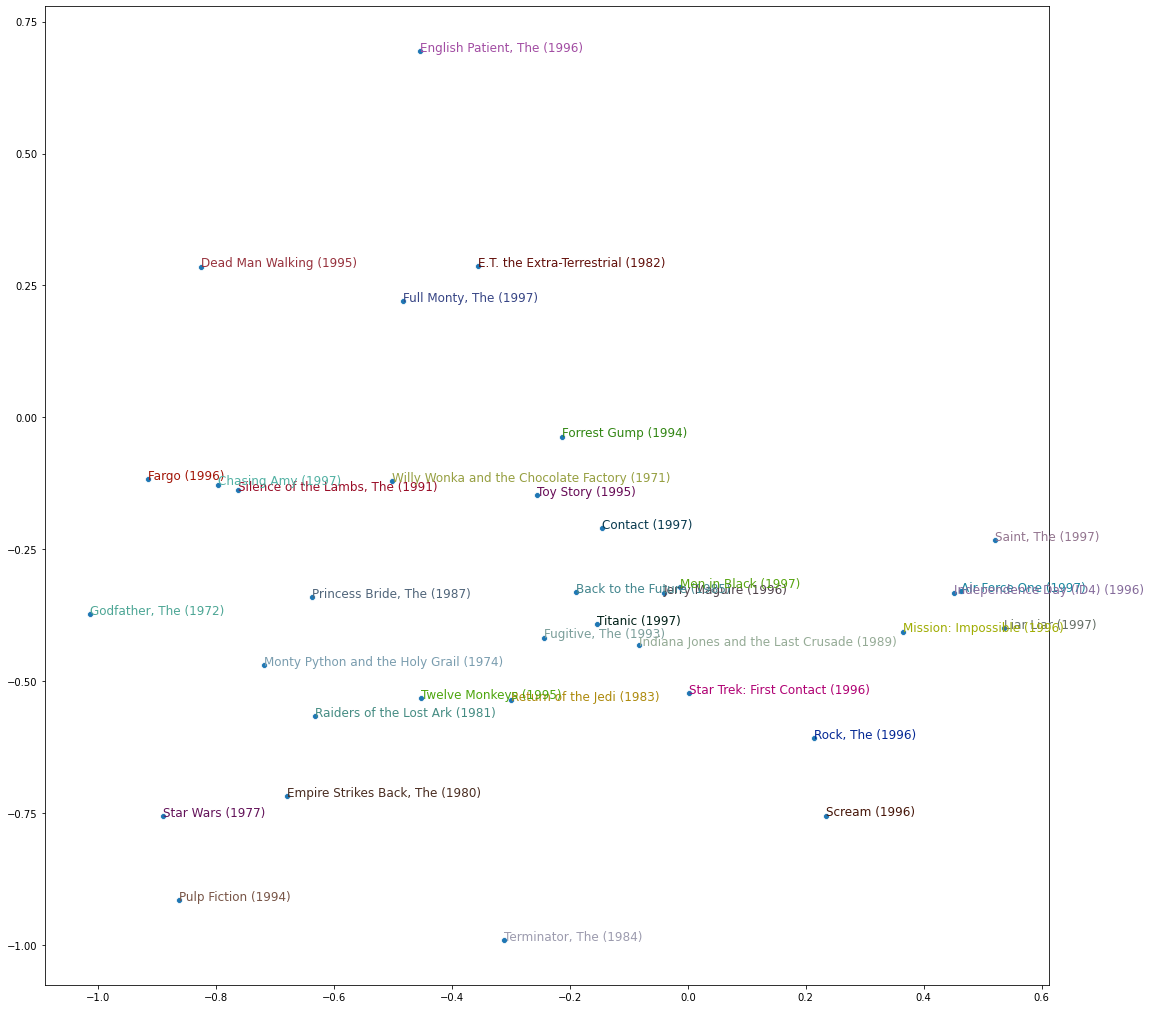

In [99]:
# idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(35))
X = f1[idxs]
Y = f3[idxs]
plt.figure(figsize=(18,18))
sns.scatterplot(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
     plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=12)
plt.show()

In [0]:
x=zip(f1,top_movies)
f1_lst=[(b,a) for a,b in x]

In [0]:
f1_df=pd.DataFrame(f1_lst,columns=['title','weight'])

In [89]:
f1_df.head()

,title,weight
0,Star Wars (1977),tensor(-0.8898)
1,Contact (1997),tensor(-0.1450)
2,Fargo (1996),tensor(-0.9157)
3,Return of the Jedi (1983),tensor(-0.2995)
4,Liar Liar (1997),tensor(0.5355)


In [0]:
f1_df=f1_df.sort_values(by='weight')

In [92]:
f1_df.head()

,title,weight
74,Casablanca (1942),tensor(-1.1360)
156,Lawrence of Arabia (1962),tensor(-1.0891)
180,Secrets & Lies (1996),tensor(-1.0325)
11,"Godfather, The (1972)",tensor(-1.0135)
304,"Close Shave, A (1995)",tensor(-1.0132)


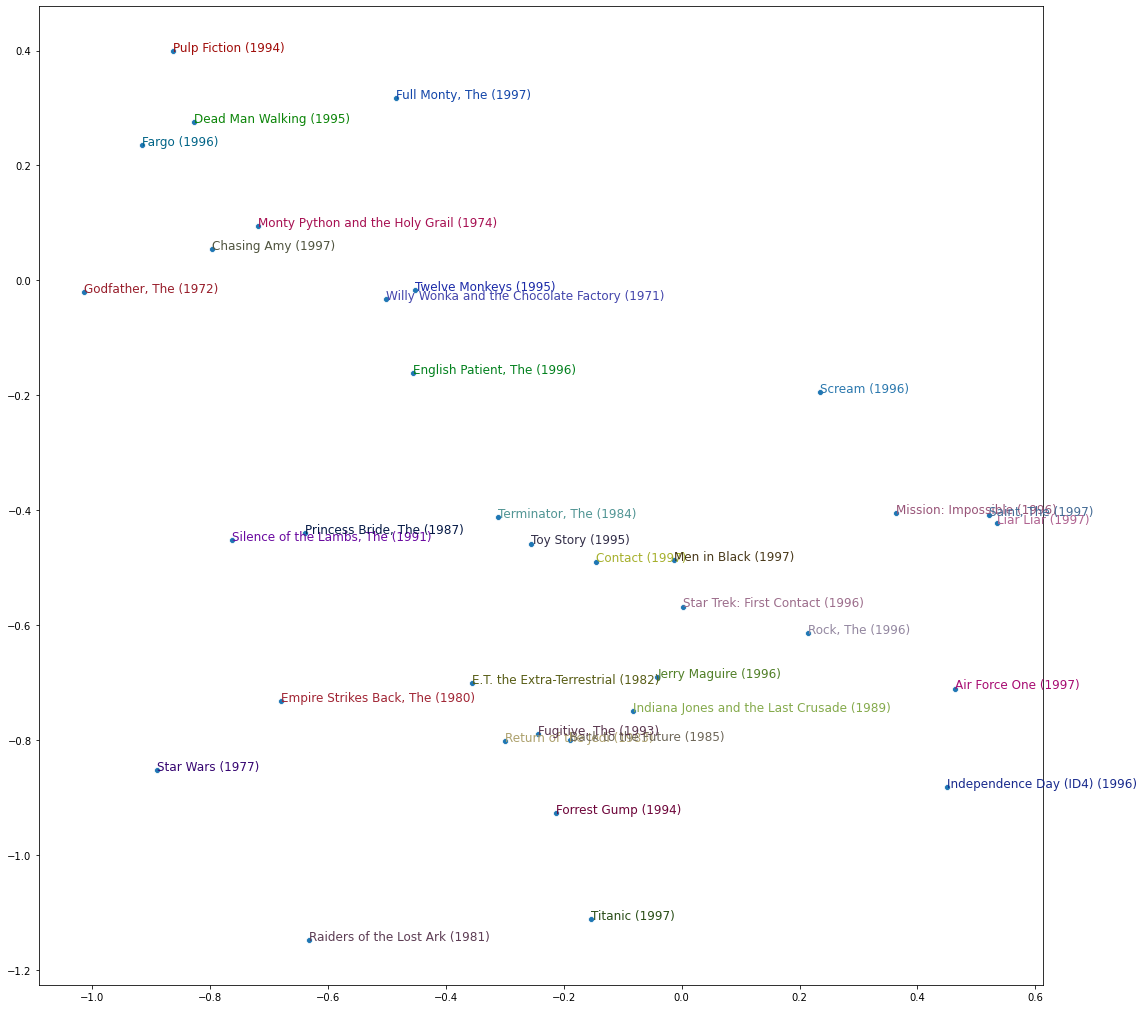

In [100]:
idxs = list(range(35))
X = f1[idxs]
Y = f2[idxs]
plt.figure(figsize=(18,18))
sns.scatterplot(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
     plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=12)
plt.show()